::: {.callout-warning}
This post is a draft.
:::

Recently, I helped design an experiment measuring a binary response against a
continuous variable. If the user abandoned their cart at time zero, then we
delayed for a variable number of minutes before reminding them to finish their
purchase. The delay has a non-monotonic relationship to the response:
as the delay increases, so does the purchase rate; then the rate peaks; and finally it decreases.

Causally, we may decompose this process into two: as the delay increases,
the user 1) becomes more available for and 2) loses interest in purchasing
the product. This is a common phenomena in different time-based scenarios. In
sports, the "aging curve" refers to how a player's performance increases with
age, then decreases. As the player gets older, they get 1) better at the sport
and 2) physically weaker.

Andrew Gelman wrote about this a couple of times in his blog: see his posts
from [2018](https://statmodeling.stat.columbia.edu/2018/09/07/bothered-non-monotonicity-heres-one-quick-trick-make-happy/)
and [2023](https://statmodeling.stat.columbia.edu/2023/01/01/how-to-model-a-non-monotonic-relation/), 
where Gelman suggests modeling these processes using an additive function like:

$$g(x) = g_1(x) + g_2(x),$$

where  
$g_1(x)$ is a monotonically increasing function with a right asymptote; and  
$g_2(x)$ is a monotonically decreasing function with a left asymptote.

In this post, we'll analyse an experimental dataset by fitting and comparing
three different models: a non-parametric bootstrap, a semi-parametric spline
and a fully parametric decomposable curve like $g(x)$.

## The Digit Span test

The motivation for Gelman's 2018 post was a study relating age to peak cognitive 
functioning [@Hartshorne2015]. According to the study, one of their experiments
was a large scale online experimentation platform:

> Participants in Experiment 2 (N = 10,394; age range = 10–69 years old) [...]
> were visitors to TestMyBrain.org, who took part in experiments in order to
> contribute to scientific research and in exchange for performance-related
> feedback. [...] We continued data collection for each experiment for approximately
> 1 year, sufficient to obtain around 10,000 participants, which allowed fine-grained
> age-of-peak-performance analysis.

The dataset for Experiment 2 is available online [@Germine_Hartshorne_2016] and 
includes results of the Digit Span verbal working memory test, part of the Wechsler 
Adult Intelligence Scale (WAIS) and Wechsler Memory Scale (WMS) supertests. In the 
Digit Span test, subjects must repeat lists of digits, either in the same or reversed 
order.


In [1]:
# | label: digit-span
import polars as pl

experiment = (
    pl.read_csv("data/experiment-2.csv")
    .with_columns(digit_span=pl.col("DigitSpan"))
    .select("age", "digit_span")
    .filter(pl.col("age").is_between(10, 70))
    .with_columns(
        y=(pl.col("digit_span") - pl.col("digit_span").mean())
        / pl.col("digit_span").std()
    )
)

Let's plot the relationship between age and Digit Span performance:


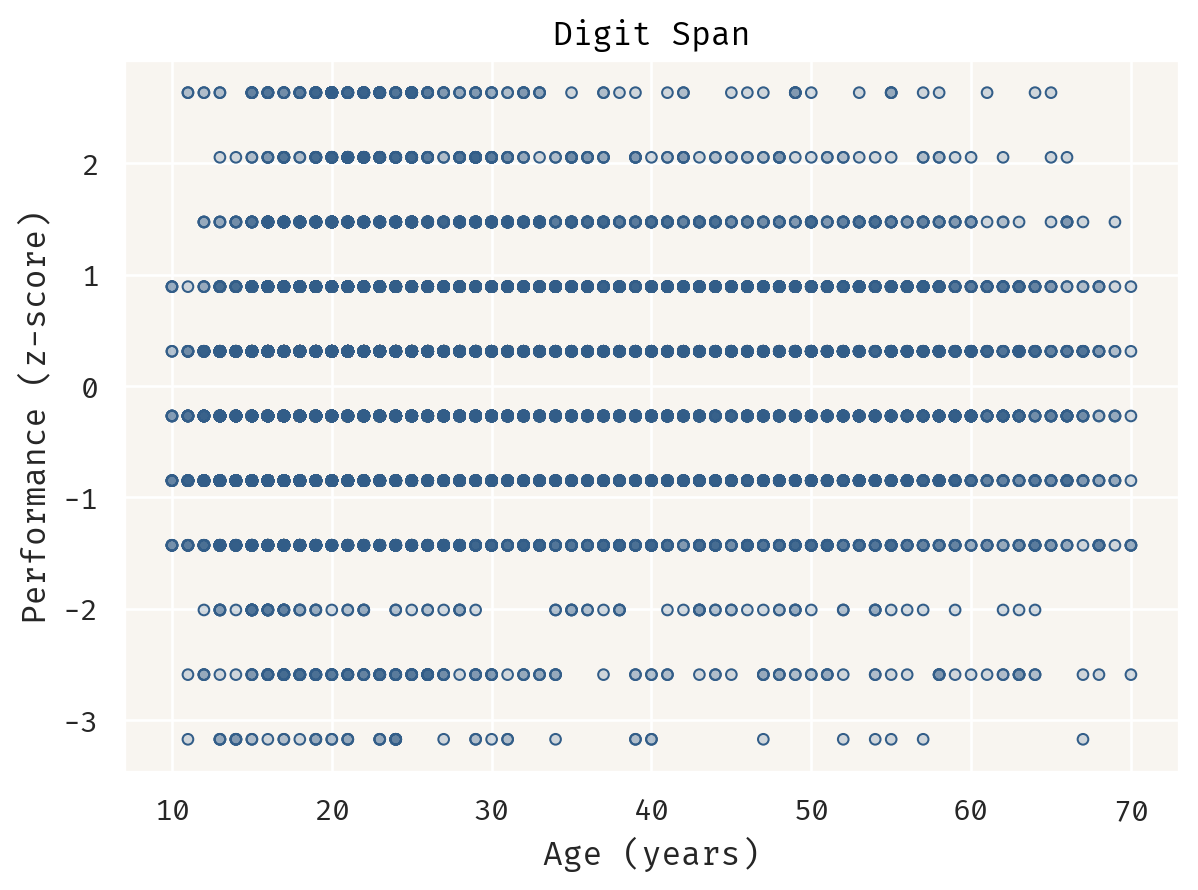

In [2]:
# | label: digit-span-plot
from blog import theme
import seaborn.objects as so

theme.set()
fig = so.Plot(experiment.to_pandas(), x="age", y="y").label(
    x="Age (years)", y="Performance (z-score)", title="Digit Span"
)
fig.add(so.Dots())

Visually, it's still unclear if this relationship follows an aging curve, but we'll get back to this matter in the next section.

## Bootstrap estimates

In the original paper, the authors describe a bootstrap resampling procedure
to estimate the distribution of ages of peak performance:

> Estimates and standard errors for age of peak performance were calculated using
> a bootstrap resampling procedure identical to the one used in Experiment 1
> but applied to raw performance data. To dampen noise, we smoothed means for each
> age using a moving 3-year window prior to identifying age of peak performance
> in each sample. Other methods of dampening noise provide similar results.

Let's decompose this method (as I understand it) into steps:

1. With replacement, sample $n$ observations from the dataset;
2. Calculate the mean performance for each sample and age;
3. Repeat steps 1 and 2 $m$ times to get multiple samples;
4. Sort each sample by age and smooth age means using a 3-year rolling average;
5. Find the age of peak performance for each sample.


In [3]:
# | label: bootstrap
# | echo: true
import polars as pl

n = experiment.height
m = 10000
nm = n * m
seed = 37
samples = (
    experiment.sample(nm, with_replacement=True, seed=seed)
    .with_columns(sample=pl.arange(1, nm + 1) % m)
    .group_by("sample", "age")
    .agg(mean=pl.col("y").mean())
    .sort("sample", "age")
    .with_columns(smoothed_mean=pl.col("mean").rolling_mean(3).over("sample"))
)
peak_performance = samples.group_by("sample").agg(
    age=pl.col("age").get(pl.col("smoothed_mean").arg_max())
)

This yields the following bootstrap distribution of ages of peak performance:


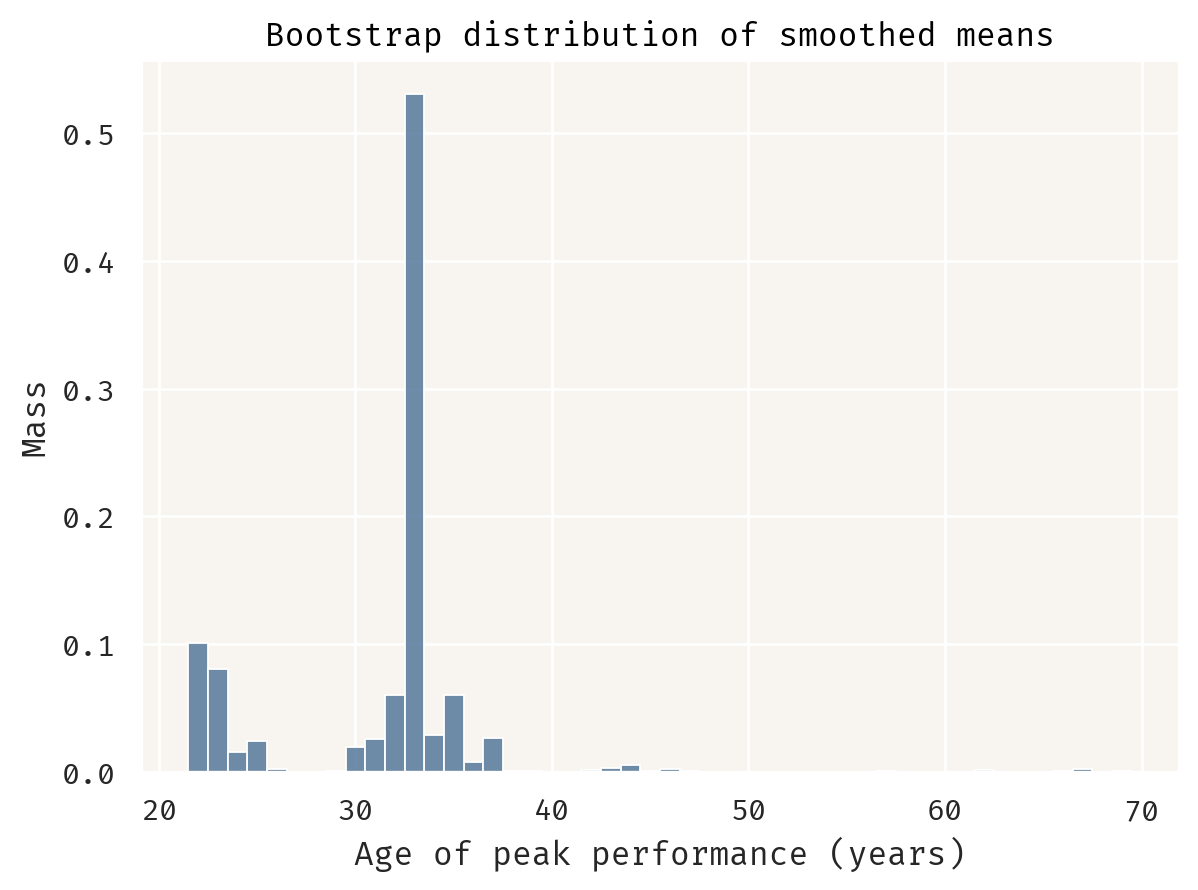

In [17]:
# | label: bootstrap-distribution
distribution = (
    peak_performance.group_by("age")
    .agg(count=pl.count())
    .with_columns(p=pl.col("count") / pl.col("count").sum())
)
so.Plot(distribution, x="age", y="p").add(so.Bars()).label(
    title="Bootstrap distribution of smoothed means",
    x="Age of peak performance (years)",
    y="Mass",
)

This distribution suggests two important things:

1. The most probable age of peak performance is, by far, 33;
2. There is a non-negligible probability that the age of peak performance happens in the early 20s, but a negligible probability that it happens in the late 20s.

Thing 2 certainly deserves attention. This is possibly caused by a confound variable or some measuring error, but I won't investigate this any further. Instead, let's get back to estimating curves. We will use the samples from step 4 to summarize the distribution of mean performances. For each age, we calculate the mean and 90% interquantile range, yielding a nonparametric curve:


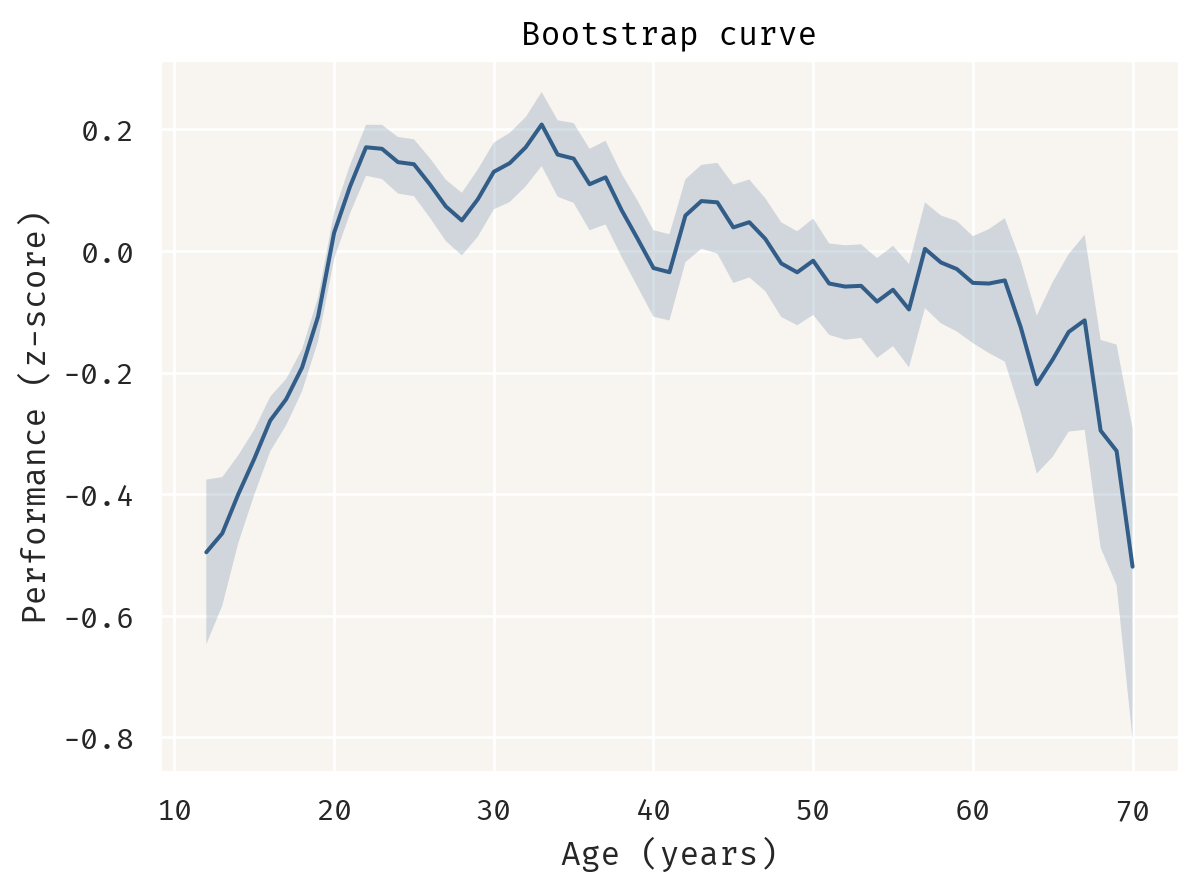

In [5]:
# | label: bootstrap-curve
def add_bands(fig: so.Plot, summary: pl.DataFrame, title: str):
    fig = (
        fig.add(so.Line(), data=summary, x="age", y="mean")
        .add(
            so.Band(),
            data=summary,
            x="age",
            y="mean",
            ymin="ymin",
            ymax="ymax",
        )
        .label(title=title)
    )
    return fig


curve = samples.group_by("age").agg(
    mean=pl.col("smoothed_mean").mean(),
    ymin=pl.col("smoothed_mean").quantile(0.05),
    ymax=pl.col("smoothed_mean").quantile(0.9),
)
add_bands(fig, curve, "Bootstrap curve")

This figure is analogue to figure ... in the paper. Since this is an entirely empirical curve, there isn't much to interpret here (maybe unitary changes?). However, the curve shape indicates an aging-curve-likeness.

## Penalized splines

Splines are wiggly curves...

$$
\begin{align}
g(x) &= \alpha + Z \bf{b} \\
y &\sim \mathrm{Normal}(g(x), \sigma) \\
\alpha &\sim \mathrm{Student}(3, 0, 0.1) \\
\sigma &\sim \mathrm{HalfCauchy}(1)
\end{align}
$$

Polynomials have runge swings...

We could make assumptions about the data generating process to help us pick the number of knots. Instead, let's pick an arbitrary large number of knots (say, 15) and let the model itself learn how wiggly the curve should be.

$$
\begin{align}
b &= \tau \bf{z} \\
\tau &\sim \mathrm{HalfCauchy}(1) \\
\bf{z} &\sim \mathrm{Normal}(0, 1)
\end{align}
$$

https://www.pymc.io/projects/examples/en/latest/howto/spline.html  
https://www.tjmahr.com/random-effects-penalized-splines-same-thing/  
https://elevanth.org/blog/2017/09/07/metamorphosis-multilevel-model/  


In [6]:
# | label: spline-basis
from patsy import dmatrix
import numpy as np


def b_spline(x: pl.Series) -> np.typing.NDArray:
    B = dmatrix(
        "bs(x, df=15, degree=3, include_intercept=True) - 1",
        {"x": x},
    )
    B = np.asarray(B, order="F")
    return B


x = experiment.get_column("age")
Z = b_spline(x)
y = experiment.get_column("y")
x_range = np.arange(x.min(), x.max() + 1)
Z_range = b_spline(x_range)
# B_range

In [7]:
# | label: spline-model
# | echo: true
# | warning: false
import pymc as pm

with pm.Model() as spline:
    Z = pm.ConstantData("Z", Z)
    α = pm.StudentT("α", 3, 0, sigma=0.1)
    τ = pm.HalfCauchy("τ", 1)
    z = pm.Normal("z", 0, 1, size=Z.shape[1])
    b = pm.Deterministic("b", τ * z)
    μ = pm.Deterministic("μ", α + pm.math.dot(Z, b.T))
    σ = pm.HalfCauchy("σ", 1)
    pm.Normal("y", μ, σ, observed=y)

In [8]:
# | label: spline-sample
with spline:
    prediction = pm.Deterministic("prediction", α + pm.math.dot(Z_range, b.T))
    draws = pm.sample(chains=4, cores=1, progressbar=False, random_seed=seed)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [α, τ, z, σ]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 47 seconds.


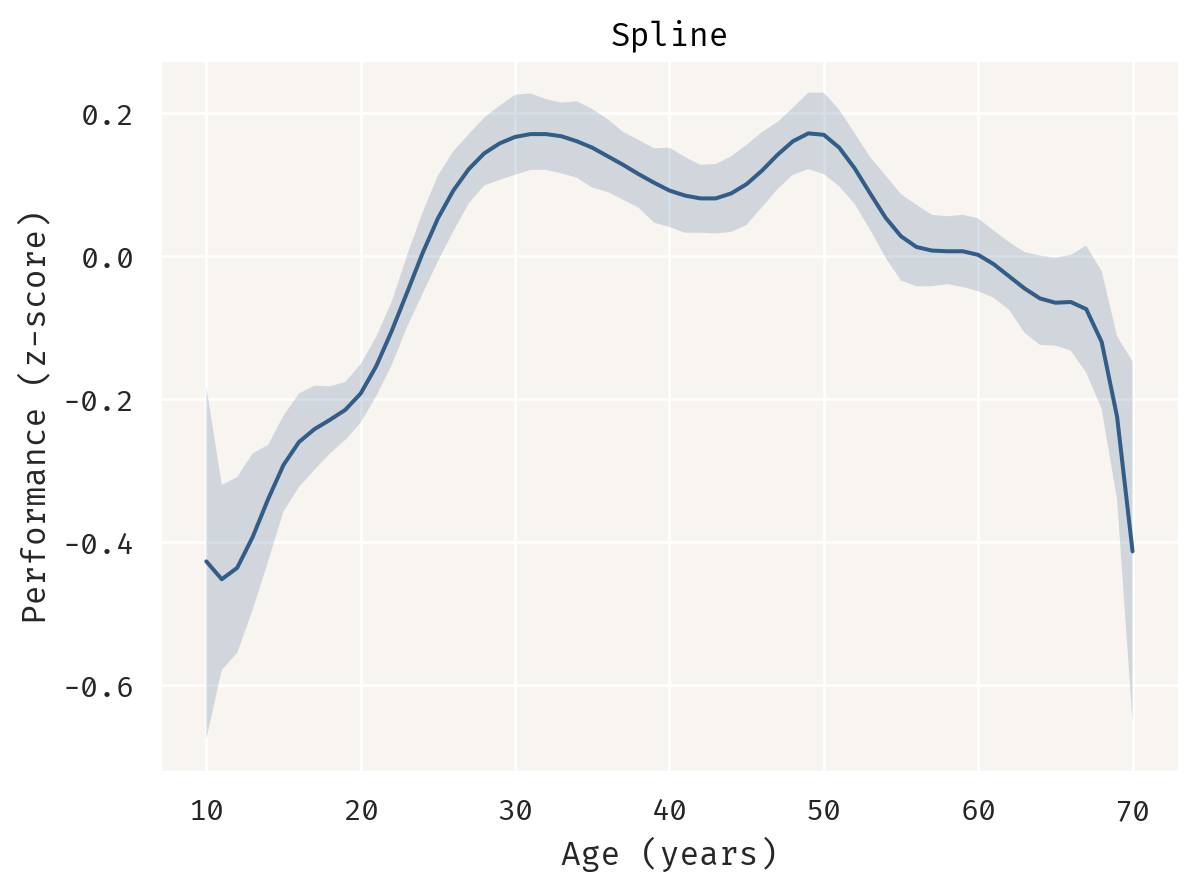

In [9]:
# | label: spline-plot
import arviz as az


def add_model(fig: so.Plot, array: az.InferenceData, title: str, hdi_prob: float = 0.9):
    summary = az.summary(array, hdi_prob=hdi_prob)
    summary["age"] = x_range
    summary["ymin"] = summary["hdi_5%"]
    summary["ymax"] = summary["hdi_95%"]
    fig = add_bands(fig, summary, title)
    return fig


# az.plot_trace(traces, var_names=["α", "τ", "b", "σ"])
# az.plot_forest(traces, var_names=["α", "b"])
add_model(fig, draws.posterior.prediction, "Spline")

Splines are good interpolation tools...  
"when, where and how things change"... https://www.youtube.com/watch?v=Zxokd_Eqrcg&t=506s  
However, it's not a good idea to extrapolate...  

## Two component function

All intervals are 80% credibility...

$$
\begin{align}
g_1(x) &= \alpha_1 + \beta_1 \exp(-\lambda_1 x) \\
g_2(x) &= \alpha_2 + \beta_2 (1 - \exp(-\lambda_2 x)) \\
g(x) &= g_1(x) + g_2(x) \\
     &= \alpha + \beta_1 \exp(-\lambda_1 x) + \beta_2 (1 - \exp(-\lambda_2 x))
\end{align}
$$

$$
\begin{align}
y &\sim \mathrm{Normal}(g(x), \sigma) \\
\alpha &\sim \mathrm{Normal}(0, 2) \\
\lambda &\sim \mathrm{Exponential}(0.01) \\
\sigma &\sim \mathrm{Exponential}(1) \\
\end{align}
$$


In [10]:
# | label: decomposable-models-additive
# | echo: true
import pymc as pm


def g(x):
    y = α[0] * pm.math.exp(-λ[0] * x) + α[1] + α[2] * (1 - pm.math.exp(-λ[1] * x))
    return y


with pm.Model() as model:
    x = pm.ConstantData("x", x)
    α = pm.Normal("alpha", 0, 2, size=3)
    λ = pm.HalfNormal("lambda", 0.01, size=2)
    μ = pm.Deterministic("mu", g(x))
    σ = pm.HalfNormal("sigma", 1)
    pm.Normal("observed", mu=μ, sigma=σ, observed=y)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, lambda, sigma]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 132 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


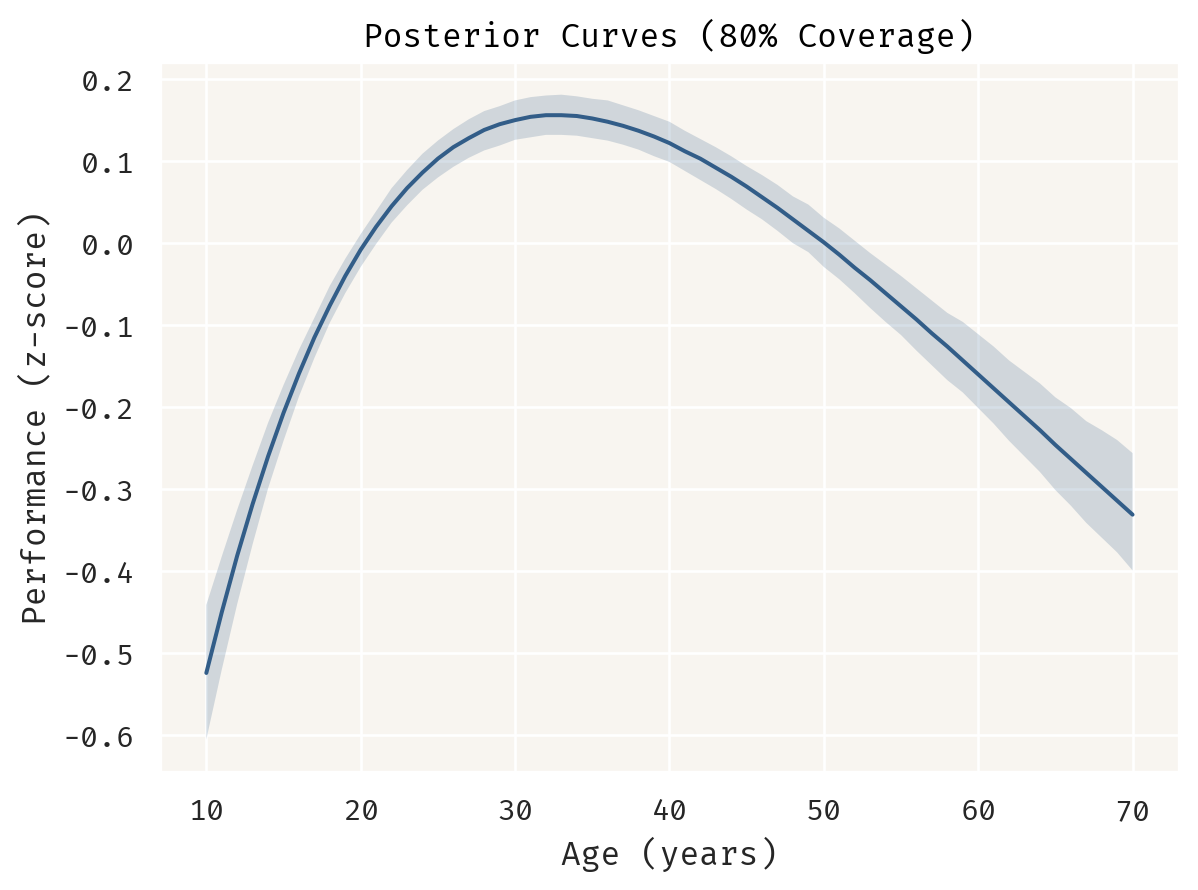

In [11]:
# | label: decomposable-models-additive-draws
# | warning: false
with model:
    prediction = pm.Deterministic("prediction", g(x_range))
    peak = pm.Deterministic(
        "peak", pm.math.log(α[0] * λ[0] / (α[2] * λ[1])) / (λ[0] - λ[1])
    )
    slope = pm.Deterministic(
        "slope",
        pm.math.log(α[0] * λ[0] ** 2 / (α[2] * λ[1] ** 2)) / (λ[0] - λ[1]),
    )
    # traces = pm.sample_prior_predictive(samples=2000, random_seed=seed)
    traces = pm.sample(progressbar=False, random_seed=seed)

# add_model(fig, traces.prior.prediction, "Prior Curves (80% Coverage)")
add_model(fig, traces.posterior.prediction, "Posterior Curves (80% Coverage)")

$$d/dx g(x) = a_2 b_2 e^(b_2 (-x)) - a_1 b_1 e^(b_1 (-x))$$
$$x = \frac{\log(\frac{a_1 b_1}{a_2 b_2})}{b_1 - b_2}$$


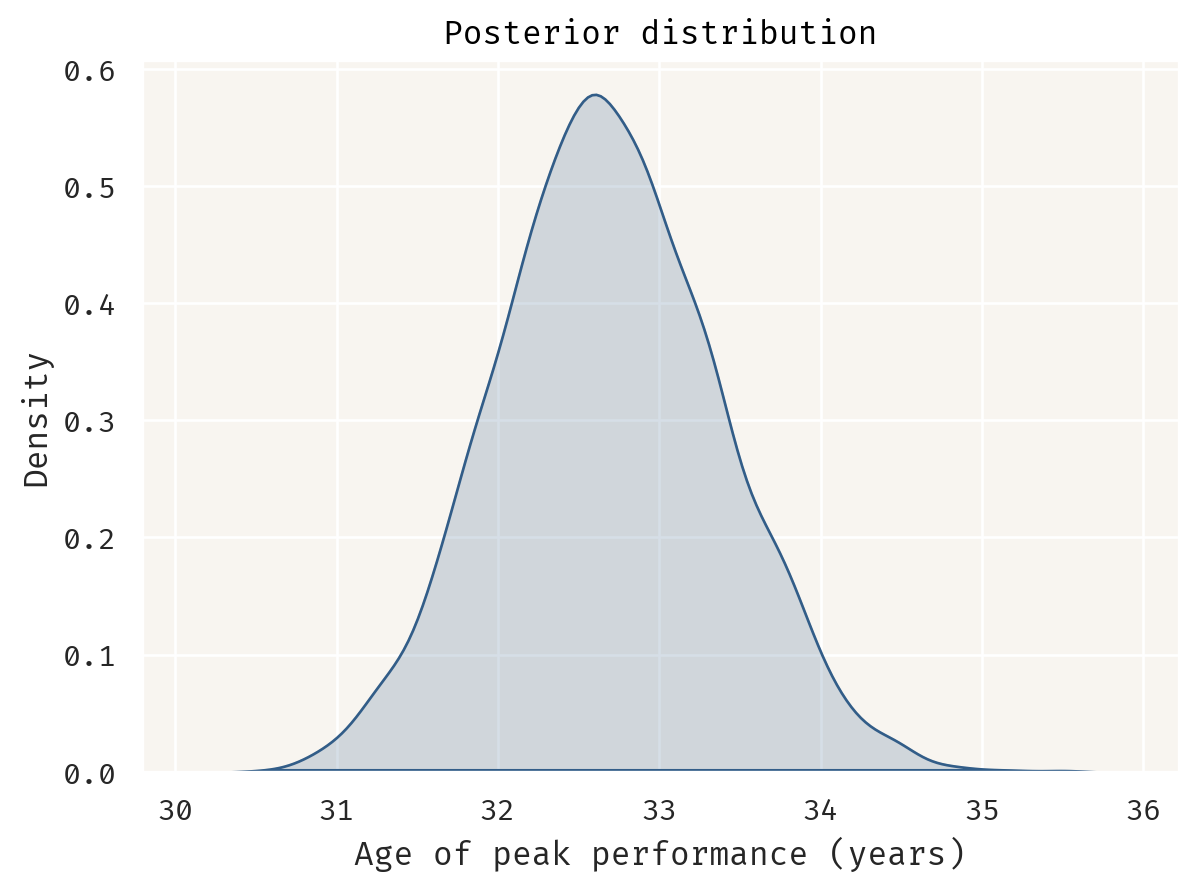

In [15]:
# | label: decomposable-models-peak
# az.plot_posterior(traces, var_names=["peak", "slope"], hdi_prob=0.8)
peak = traces.posterior.peak.to_dataframe()
so.Plot(peak, x="peak").add(so.Area(), so.KDE()).label(
    title="Posterior distribution", x="Age of peak performance (years)", y="Density"
)